In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
BATCH_SIZE = 64
LR = 0.0001  # Lower learning rate for stability
N_EPOCHS = 50  # More epochs
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Running DANN on {DEVICE}")

Running DANN on cuda


In [40]:
#Loading data
X_pdb = np.load('/content/drive/MyDrive/features/pdb_maps.npy')
X_af = np.load('/content/drive/MyDrive/features/af_maps.npy')
y = np.load('/content/drive/MyDrive/features/labels.npy')

# Split (same as naive)
indices = np.arange(len(y))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=y)

X_train_pdb = X_pdb[train_idx]
X_train_af = X_af[train_idx]
y_train = y[train_idx]

X_test_pdb = X_pdb[test_idx]
X_test_af = X_af[test_idx]
y_test = y[test_idx]

print(f"Train: {len(X_train_pdb)} | Test: {len(X_test_af)}")

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

Train: 9641 | Test: 2411


In [41]:
#Data loaders
source_ds = TensorDataset(
    torch.tensor(X_train_pdb, dtype=torch.float32).unsqueeze(1),
    torch.tensor(y_train, dtype=torch.long)
)
source_loader = DataLoader(source_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

target_ds = TensorDataset(
    torch.tensor(X_train_af, dtype=torch.float32).unsqueeze(1),
    torch.tensor(y_train, dtype=torch.long)
)
target_loader = DataLoader(target_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_pdb_ds = TensorDataset(
    torch.tensor(X_test_pdb, dtype=torch.float32).unsqueeze(1),
    torch.tensor(y_test, dtype=torch.long)
)
test_af_ds = TensorDataset(
    torch.tensor(X_test_af, dtype=torch.float32).unsqueeze(1),
    torch.tensor(y_test, dtype=torch.long)
)
test_pdb_loader = DataLoader(test_pdb_ds, batch_size=BATCH_SIZE)
test_af_loader = DataLoader(test_af_ds, batch_size=BATCH_SIZE)

In [42]:
#GRL
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradientReversalFunction.apply(x, lambda_)

In [43]:
#Model
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv(x)
        x = self.gap(x)
        return x.view(x.size(0), -1)

class LabelClassifier(nn.Module):
    def __init__(self, input_dim=256, num_classes=7):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

class DomainDiscriminator(nn.Module):
    def __init__(self, input_dim=256):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)

class DANN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.label_classifier = LabelClassifier(256, num_classes)
        self.domain_discriminator = DomainDiscriminator(256)

    def forward(self, x, lambda_=1.0):
        features = self.feature_extractor(x)
        class_output = self.label_classifier(features)
        domain_output = self.domain_discriminator(grad_reverse(features, lambda_))
        return class_output, domain_output, features

In [44]:
#Training loop
model = DANN(num_classes=7).to(DEVICE)
class_criterion = nn.CrossEntropyLoss(weight=class_weights)
domain_criterion = nn.BCEWithLogitsLoss()

# Separate optimizers for better control
optimizer_f = optim.Adam(model.feature_extractor.parameters(), lr=LR)
optimizer_c = optim.Adam(model.label_classifier.parameters(), lr=LR)
optimizer_d = optim.Adam(model.domain_discriminator.parameters(), lr=LR)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            class_out, _, _ = model(X)
            preds = class_out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

# Track best model
best_af_acc = 0
best_epoch = 0

print("\n=== Training DANN ===")

for epoch in range(N_EPOCHS):
    model.train()

    # Slower lambda warmup
    p = epoch / N_EPOCHS
    lambda_ = 0.5 * (2 / (1 + np.exp(-5 * p)) - 1)  # Max out at 0.5 instead of 1.0

    total_class_loss = 0
    total_domain_loss = 0

    target_iter = iter(target_loader)

    for source_x, source_y in source_loader:
        try:
            target_x, _ = next(target_iter)
        except StopIteration:
            target_iter = iter(target_loader)
            target_x, _ = next(target_iter)

        source_x, source_y = source_x.to(DEVICE), source_y.to(DEVICE)
        target_x = target_x.to(DEVICE)

        domain_source = torch.zeros(source_x.size(0), 1).to(DEVICE)
        domain_target = torch.ones(target_x.size(0), 1).to(DEVICE)

        # Forward
        class_out, domain_out_s, _ = model(source_x, lambda_)
        _, domain_out_t, _ = model(target_x, lambda_)

        # Losses
        class_loss = class_criterion(class_out, source_y)
        domain_loss = domain_criterion(domain_out_s, domain_source) + \
                      domain_criterion(domain_out_t, domain_target)

        total_loss = class_loss + 0.5 * domain_loss  # Weight domain loss lower

        # Update all
        optimizer_f.zero_grad()
        optimizer_c.zero_grad()
        optimizer_d.zero_grad()
        total_loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer_f.step()
        optimizer_c.step()
        optimizer_d.step()

        total_class_loss += class_loss.item()
        total_domain_loss += domain_loss.item()

    # Evaluate every epoch
    pdb_acc = evaluate(model, test_pdb_loader)
    af_acc = evaluate(model, test_af_loader)

    # Save best model
    if af_acc > best_af_acc:
        best_af_acc = af_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'dann_best.pth')

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{N_EPOCHS} | λ={lambda_:.2f} | Class Loss: {total_class_loss/len(source_loader):.4f} | PDB: {pdb_acc:.2f}% | AF: {af_acc:.2f}%")





=== Training DANN ===
Epoch 5/50 | λ=0.10 | Class Loss: 0.8105 | PDB: 64.00% | AF: 64.33%
Epoch 10/50 | λ=0.21 | Class Loss: 0.6153 | PDB: 67.81% | AF: 66.90%
Epoch 15/50 | λ=0.30 | Class Loss: 0.4877 | PDB: 70.26% | AF: 69.56%
Epoch 20/50 | λ=0.37 | Class Loss: 0.3779 | PDB: 65.95% | AF: 63.79%
Epoch 25/50 | λ=0.42 | Class Loss: 0.2766 | PDB: 63.46% | AF: 62.63%
Epoch 30/50 | λ=0.45 | Class Loss: 0.2054 | PDB: 81.25% | AF: 79.76%
Epoch 35/50 | λ=0.47 | Class Loss: 0.1491 | PDB: 79.88% | AF: 78.89%
Epoch 40/50 | λ=0.48 | Class Loss: 0.1047 | PDB: 67.57% | AF: 66.03%
Epoch 45/50 | λ=0.49 | Class Loss: 0.0750 | PDB: 65.37% | AF: 62.67%
Epoch 50/50 | λ=0.49 | Class Loss: 0.0665 | PDB: 76.98% | AF: 76.48%


In [45]:
#Final results
model.load_state_dict(torch.load('dann_best.pth'))

print(f"\n=== DANN Final Results (Best @ Epoch {best_epoch}) ===")
pdb_acc = evaluate(model, test_pdb_loader)
af_acc = evaluate(model, test_af_loader)

print(f"Accuracy on PDB:       {pdb_acc:.2f}%")
print(f"Accuracy on AlphaFold: {af_acc:.2f}%")
print(f"Gap: {pdb_acc - af_acc:.2f}%")


=== DANN Final Results (Best @ Epoch 44) ===
Accuracy on PDB:       87.76%
Accuracy on AlphaFold: 86.27%
Gap: 1.49%


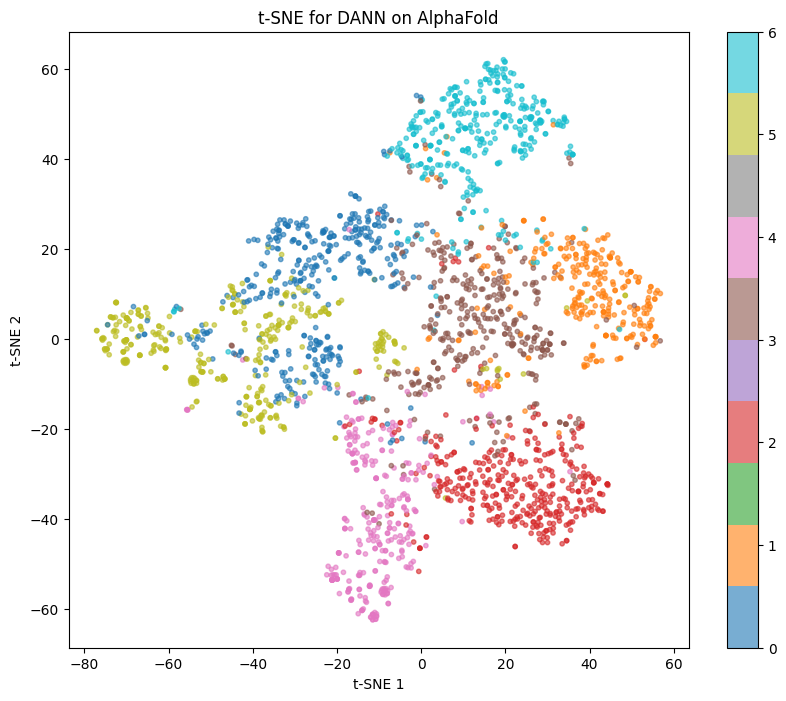

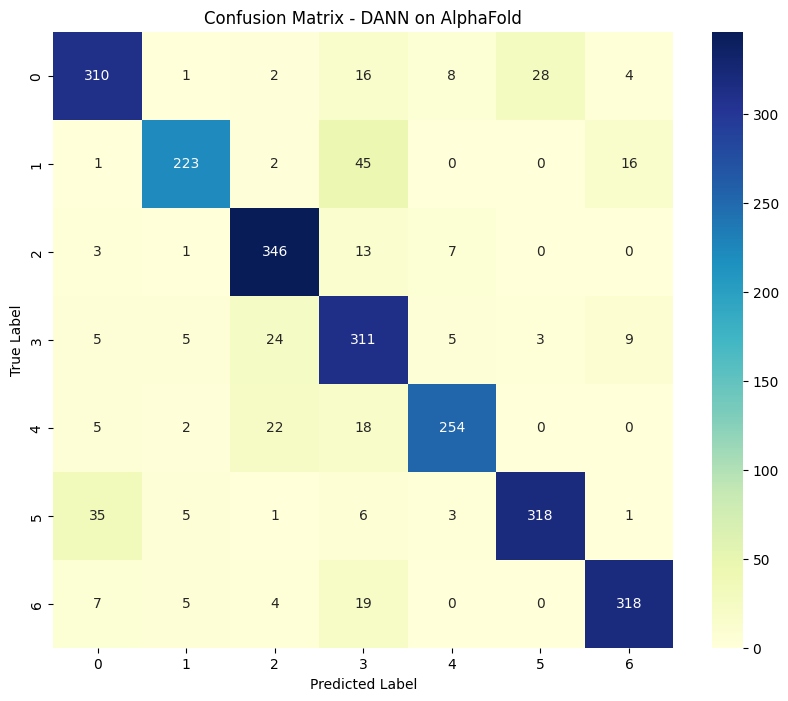


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       369
           1       0.92      0.78      0.84       287
           2       0.86      0.94      0.90       370
           3       0.73      0.86      0.79       362
           4       0.92      0.84      0.88       301
           5       0.91      0.86      0.89       369
           6       0.91      0.90      0.91       353

    accuracy                           0.86      2411
   macro avg       0.87      0.86      0.86      2411
weighted avg       0.87      0.86      0.86      2411



In [47]:
#Visualisations
model.eval()
features = []
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y_batch in test_af_loader:
        X = X.to(DEVICE)
        feat = model.feature_extractor(X)
        class_out, _, _ = model(X)
        preds = class_out.argmax(dim=1)

        features.append(feat.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.numpy())

features = np.concatenate(features)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter)
plt.title('t-SNE for DANN on AlphaFold')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('dann_tsne.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix - DANN on AlphaFold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('dann_confusion.png')
plt.show()

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds))